In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
class Balls:
    
    def __init__(self, N, dim, boundary, T, Temp, k=1, m=1):
        
        self.N        = N
        self.k        = k
        self.T        = T
        self.dim      = dim
        self.Temp     = Temp
        self.boundary = boundary
        
        np.random.seed(0)
        
        self.pos = 2*np.random.rand(N,dim)-1

        np.random.seed(1)
        
        v             = np.sqrt(k*Temp/m)
        theta         = 2*np.pi*np.random.rand(N)
        self.vel      = np.zeros((N,dim))
        self.vel[:,0] = v*np.cos(theta)
        self.vel[:,1] = v*np.sin(theta)
        
        self.rad  = 0.2*np.ones(N)
        self.mass = m*np.ones(N)
        
        self.t      = [0]
        self.tc     = []
        self.tc_all = np.full((N,2*dim+N), float(T))
        
        self.results_pos = []
        self.results_vel = []
        
        return
    
    def evolve_analytical(self):
        
        t       = self.t[0]
        T       = self.T
        record  = self.record
        iterate = self.iterate_analytical
        
        record()
        
        while t < T:
    
            iterate()
            
            t = self.t[-1]
        
        self.tc.pop() 
        
        return
    
    def evolve_CCD(self, n):
        
        t       = self.t[0]
        N       = self.N
        R       = self.rad
        T       = self.T
        BC      = self.boundary
        dim     = self.dim
        record  = self.record
        iterate = self.iterate_CCD
        
        time = np.linspace(t,T,n)
        
        for t_f in time:
            
            if t_f == 0:
                
                record()
                
            else:
                
                while t < t_f:
                    
                    dt_f = t_f - t
                    
                    pos_f = self.pos + self.vel*dt_f
                    
                    collision_index = np.full((N,2*dim+N), False)
                    
                    collision_index[:,0:dim]     = pos_f + R >  BC
                    collision_index[:,dim:2*dim] = pos_f - R < -BC
                    
                    x_f  = pos_f[:,0]
                    y_f  = pos_f[:,1]
                    
                    x_f_i, x_f_j = np.meshgrid(x_f, x_f, indexing='ij')
                    y_f_i, y_f_j = np.meshgrid(y_f, y_f, indexing='ij')
                    
                    x_f_ij = x_f_j - x_f_i
                    y_f_ij = y_f_j - y_f_i
                    r_f_ij = np.sqrt(x_f_ij**2+y_f_ij**2)
                    
                    Ri, Rj = np.meshgrid(R,R,indexing='ij')
                    
                    Rij = Ri + Rj
                    
                    collision_index[:,2*dim:] = r_f_ij < Rij
                    
                    if np.any(collision_index):
                        
                        self.collision_index = collision_index.copy()
        
        return
    
    def iterate_analytical(self):
        
        move             = self.move
        tc_BC            = self.tc_boundary
        record           = self.record
        tc_min           = self.tc_min
        collide_BC       = self.collide_boundary
        tc_balls_2D      = self.tc_balls_2D
        collide_balls_2D = self.collide_balls_2D
        
        tc_BC()
        
        tc_balls_2D()
        
        tc_min()
        
        dt = min(self.tc[-1],T-self.t[-1])
        
        move(dt)
        
        index_BC   = self.collision_index[:,0:2*dim]
        index_Ball = self.collision_index[:,2*dim:]
        
        if np.any(index_BC):
            collide_BC()
        elif np.any(index_Ball):
            collide_balls_2D()
        else:
            pass
                
        self.t.append(self.t[-1]+dt)
            
        record()
        
        return
    
    def record(self):
        
        pos = self.pos.copy()
        vel = self.vel.copy()
        
        self.results_pos.append(pos)
        self.results_vel.append(vel)
        
        return
    
    def move(self, dt):
        
        pos = self.pos
        vel = self.vel
        
        pos = pos + vel*dt
        
        self.pos = pos
        
        return
    
    def tc_boundary(self):
        
        R       = self.rad
        T       = self.T
        BC      = self.boundary
        dim     = self.dim
        pos     = self.pos
        vel     = self.vel
        
        tc_BC_u = np.full(pos.shape, float(T)) # tc for upper boundary
        tc_BC_d = np.full(pos.shape, float(T)) # tc for lower boundary
        
        U = vel>0
        D = vel<0
    
        tc_BC_u[U] = ( BC - pos[U] )/vel[U]
        tc_BC_d[D] = (-BC - pos[D] )/vel[D]
        
        self.tc_all[:,0:dim]     = tc_BC_u
        self.tc_all[:,dim:2*dim] = tc_BC_d
        
        return
    
    def tc_balls_2D(self):
        
        R   = self.rad
        T   = self.T
        dim = self.dim
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]

        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        Ri, Rj = np.meshgrid(R,R,indexing='ij')

        xij  = xj - xi
        yij  = yj - yi
        vxij = vxj - vxi
        vyij = vyj - vyi

        Rij = Rj + Ri
        
        J = np.full(Rij.shape,True)
        J = np.triu(J, k=1)          # upper triangle to speedup

        r_d_v = np.zeros(Rij.shape)
        r_s   = r_d_v.copy()
        v_s   = r_d_v.copy()
        R_s   = r_d_v.copy()
        D     = r_d_v.copy()
        
        r_d_v[J]  = xij[J]*vxij[J] + yij[J]*vyij[J]    # r dot v
        r_s[J]    = xij[J]**2 + yij[J]**2              # r square
        v_s[J]    = vxij[J]**2 + vyij[J]**2            # v square
        R_s[J]    = Rij[J]**2                          # R square
        D[J]      = r_d_v[J]**2-v_s[J]*(r_s[J]-R_s[J]) # Discriminant
        J         = D>0

        tc_balls      = np.full(Rij.shape, float(T))
        tc_balls[J]   = (-r_d_v[J] - np.sqrt(D[J]))/v_s[J]
        tc_balls[J.T] = tc_balls.T[J.T]
        
        tc_balls[tc_balls<=0] = T
        
        self.tc_all[:,2*dim:] = tc_balls
        
        return
    
    def tc_min(self):
        
        tc_all = self.tc_all
        self.tc.append(np.min(tc_all))
        self.collision_index = tc_all==np.min(tc_all)
        
        return
    
    def collide_boundary(self):
        
        dim      = self.dim
        vel      = self.vel
        index_BC = self.collision_index[:,0:2*dim]
        
        vel[index_BC[:,0:dim]] = -vel[index_BC[:,0:dim]]
        vel[index_BC[:,dim:]]  = -vel[index_BC[:,dim:]]
        
        self.vel = vel
    
        return
    
    def collide_balls_2D(self):
        
        i   = self.collision_index[:,2*dim:]
        m   = self.mass
        pos = self.pos
        vel = self.vel
        
        x  = pos[:,0]
        y  = pos[:,1]
        vx = vel[:,0]
        vy = vel[:,1]
        
        xi, xj   = np.meshgrid(x,x,indexing='ij')
        yi, yj   = np.meshgrid(y,y,indexing='ij')
        mi, mj   = np.meshgrid(m,m,indexing='ij')
        vxi, vxj = np.meshgrid(vx,vx,indexing='ij')
        vyi, vyj = np.meshgrid(vy,vy,indexing='ij')

        xij  = xi - xj
        yij  = yi - yj
        vxij = vxi - vxj
        vyij = vyi - vyj
        
        C    = np.zeros(mi.shape)
        C[i] = 2*mj[i]/(mi[i]+mj[i])*(vxij[i]*xij[i]+vyij[i]*yij[i])/(xij[i]**2+yij[i]**2)
        
        vx_f    = np.zeros(mi.shape)
        vx_f[i] = vxi[i] - C[i]*xij[i]
        vy_f    = np.zeros(mi.shape)
        vy_f[i] = vyi[i] - C[i]*yij[i]
        
        vx_f = np.sum(vx_f,axis=1)
        vy_f = np.sum(vy_f,axis=1)
        
        i_1D = np.any(i, axis=1)
        
        vx[i_1D] = vx_f[i_1D]
        vy[i_1D] = vy_f[i_1D]
        
        vel[:,0] = vx.copy()
        vel[:,1] = vy.copy()
        
        self.vel = vel
        
        return


In [3]:
numbers  = 10                    # particle numbers
dim      = 2                     # dimension
boundary = 4                     # boundary
T        = 100                    # total time
Temp     = 50                    # Temperature

balls = Balls(numbers, dim, boundary, T, Temp) # balls

balls.evolve_analytical()

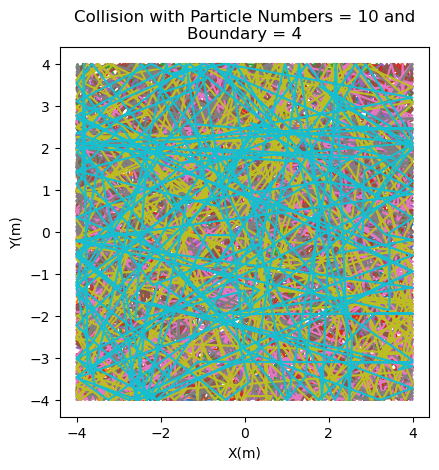

In [4]:
 
N    = balls.N
BC   = balls.boundary
pos  = np.array(balls.results_pos)

for i in range(N):
            
    plt.plot(pos[:,i,0], pos[:,i,1])
        
plt.axis('square')
plt.title(f'Collision with Particle Numbers = {N} and\nBoundary = {BC}')
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.savefig(f'N_{N}_particles_with_boundary.png')
        

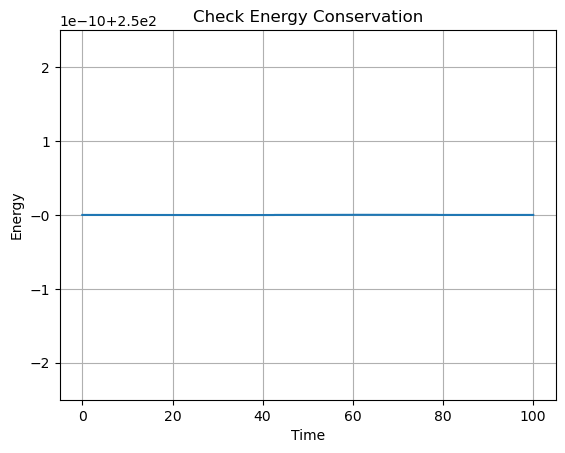

In [5]:
t   = balls.t
m   = balls.mass
vel = np.array(balls.results_vel)
E   = []

for i in range(len(t)):
    E.append(0.5*np.sum(m*(vel[i,:,0]**2+vel[i,:,1]**2)))

plt.plot(t,E)
plt.grid()
plt.title('Check Energy Conservation')
plt.xlabel('Time')
plt.ylabel('Energy');

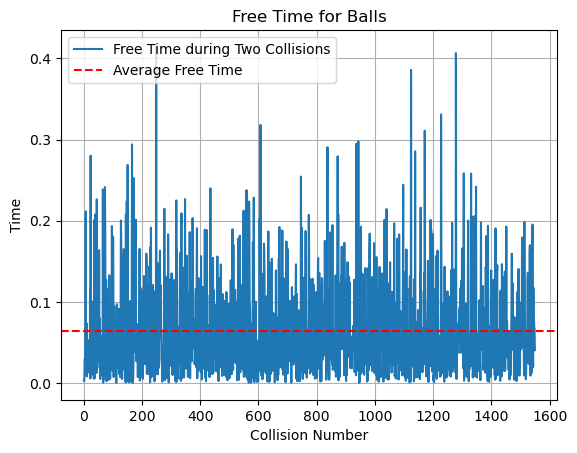

In [6]:

tc = balls.tc
x = [i+1 for i in range(len(tc))]
plt.plot(x,tc,label='Free Time during Two Collisions')
plt.axhline(y=np.sum(tc)/len(tc), color='r', linestyle='--',label='Average Free Time')
plt.grid()
plt.legend()
plt.title('Free Time for Balls')
plt.xlabel('Collision Number')
plt.ylabel('Time');


AttributeError: 'silent_list' object has no attribute 'patches'

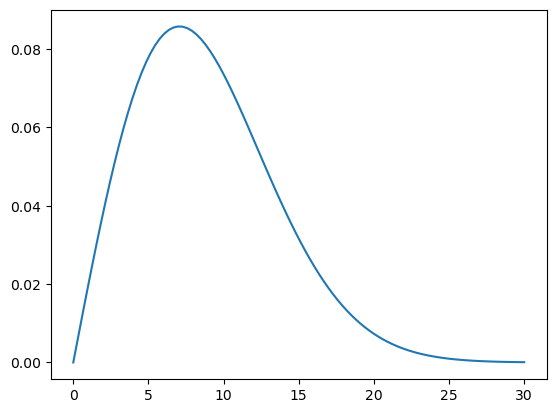

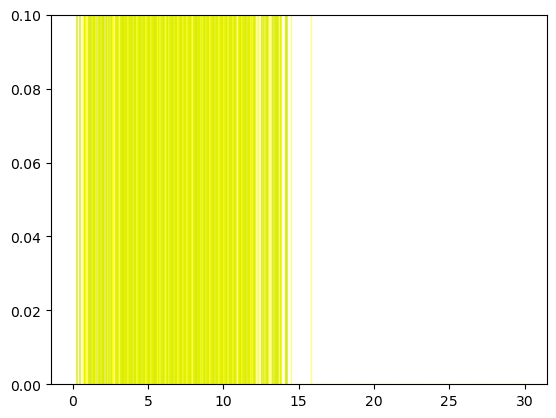

In [7]:
def f(v, Temp, k=1, m=1):
    sigma_s = m/k/Temp
    return (sigma_s*v)*np.exp(-0.5*sigma_s*v**2)

v = np.linspace(0,30,100)
plt.plot(v,f(v, Temp))

vel   = np.array(balls.results_vel)
speed = np.sqrt(vel[:,:,0]**2+vel[:,:,1]**2)

HIST_BINS = np.linspace(0, 30, 100)

def prepare_animation(bar_container):

    def animate(frame_number):
        # simulate new data coming in
        data = speed
        n, _ = np.histogram(data, HIST_BINS)
        for count, rect in zip(n, bar_container.patches):
            rect.set_height(count)
        return bar_container.patches
    
    return animate

fig, ax = plt.subplots()
_, _, bar_container = ax.hist(speed, HIST_BINS, lw=1,
                              ec="yellow", fc="green", alpha=0.5)
ax.set_ylim(top=0.1)  # set safe limit to ensure that all data is visible.

ani = animation.FuncAnimation(fig, prepare_animation(bar_container), 50,
                              repeat=False, blit=True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

n = 100
number_of_frames = 10
data = np.random.rand(n, number_of_frames)

def update_hist(num, data):
    plt.cla()
    plt.hist(data[num])

fig = plt.figure()
hist = plt.hist(data[0])

ani = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(data, ) )

plt.show()

f = "try.gif" 
writergif = animation.PillowWriter(fps=30) 
ani.save(f, writer=writergif)